In [6]:
from pathlib import Path

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import umap
import umap.plot

from sklearn.cluster import KMeans

In [8]:
import datashader as ds
import datashader.transfer_functions as tf

In [9]:
import joblib

### centers.csv is extracted from the xml file

In [14]:
centers = pd.read_csv('ea5/centers_fov64.csv', low_memory=False)

In [15]:
centers

,well,fov,resolution_x,resolution_y,center_x,center_y
0,B10,1,0.149494,0.149494,27943.570692,2934.417855
1,B10,2,0.149494,0.149494,26716.523692,2014.132855
2,B10,3,0.149494,0.149494,27023.285692,2014.132855
3,B10,4,0.149494,0.149494,27330.046692,2014.132855
4,B10,5,0.149494,0.149494,27636.808692,2014.132855
...,...,...,...,...,...,...
3515,J8,60,0.149494,0.149494,21767.972983,28863.855692
3516,J8,61,0.149494,0.149494,21461.210983,28863.855692
3517,J8,62,0.149494,0.149494,21154.448983,28863.855692
3518,J8,63,0.149494,0.149494,20847.687983,28863.855692


In [16]:
centers.rename(columns={'fov':'fov_64'}, inplace=True)

In [17]:
centers

,well,fov_64,resolution_x,resolution_y,center_x,center_y
0,B10,1,0.149494,0.149494,27943.570692,2934.417855
1,B10,2,0.149494,0.149494,26716.523692,2014.132855
2,B10,3,0.149494,0.149494,27023.285692,2014.132855
3,B10,4,0.149494,0.149494,27330.046692,2014.132855
4,B10,5,0.149494,0.149494,27636.808692,2014.132855
...,...,...,...,...,...,...
3515,J8,60,0.149494,0.149494,21767.972983,28863.855692
3516,J8,61,0.149494,0.149494,21461.210983,28863.855692
3517,J8,62,0.149494,0.149494,21154.448983,28863.855692
3518,J8,63,0.149494,0.149494,20847.687983,28863.855692


### Open metcenter and umap coordinates

In [26]:
umap_coords = pd.read_csv('ea5/all_julius_interactive plot.csv', low_memory=False)
metc_coords = pd.read_csv('ea5/metcenters.csv', low_memory=False)
features = metc_coords.merge(umap_coords, on=['donor','fov','well','id']).reset_index()

In [28]:
features.rename(columns={'fov':'fov_256'}, inplace=True)
features

,index,NUCLEUS METCENTER-X,NUCLEUS METCENTER-Y,well,fov_256,donor,id,umap_x,umap_y
0,0,3799.229492,21876.675781,H2,159,AML1_M2,9,-1.207413,5.416854
1,1,3905.091064,4040.277588,B2,234,AML1_M2,1,1.668570,5.921109
2,2,3974.551758,4129.835938,B2,234,AML1_M2,7,-1.211912,5.889323
3,3,3892.813477,4116.119629,B2,234,AML1_M2,12,-1.311539,5.806268
4,4,3856.181641,4145.979980,B2,234,AML1_M2,16,3.439832,-0.883217
...,...,...,...,...,...,...,...,...,...
52201,52201,53157.781250,2883.951416,B18,109,Donor_141,44,-2.943622,-2.181488
52202,52202,53250.867188,2785.493652,B18,109,Donor_141,46,-0.468263,8.207773
52203,52203,53114.757812,2867.605469,B18,109,Donor_141,57,0.092512,-0.518103
52204,52204,53225.570312,2932.076904,B18,109,Donor_141,62,2.321954,2.511270


In [37]:
features.fov_256 = features.fov_256.astype('int64')

### Match 64 FOVS with their 256 FOVs crops

In [40]:
fov_256_min_n = features.fov_256.min()
fov_64_min_n = centers.fov_64.min()
fov_256_min_n, fov_64_min_n

(5, 1)

In [44]:
B = np.arange(256)
A = B//4
A += fov_64_min_n
B += fov_256_min_n
fovdict = {}
for a, b in zip(A, B):
    fovdict[b] = a

In [47]:
features['fov_64'] = [fovdict[onefov] for onefov in features.fov_256]

In [48]:
features

,index,NUCLEUS METCENTER-X,NUCLEUS METCENTER-Y,well,fov_256,donor,id,umap_x,umap_y,fov_64
0,0,3799.229492,21876.675781,H2,159,AML1_M2,9,-1.207413,5.416854,39
1,1,3905.091064,4040.277588,B2,234,AML1_M2,1,1.668570,5.921109,58
2,2,3974.551758,4129.835938,B2,234,AML1_M2,7,-1.211912,5.889323,58
3,3,3892.813477,4116.119629,B2,234,AML1_M2,12,-1.311539,5.806268,58
4,4,3856.181641,4145.979980,B2,234,AML1_M2,16,3.439832,-0.883217,58
...,...,...,...,...,...,...,...,...,...,...
52201,52201,53157.781250,2883.951416,B18,109,Donor_141,44,-2.943622,-2.181488,27
52202,52202,53250.867188,2785.493652,B18,109,Donor_141,46,-0.468263,8.207773,27
52203,52203,53114.757812,2867.605469,B18,109,Donor_141,57,0.092512,-0.518103,27
52204,52204,53225.570312,2932.076904,B18,109,Donor_141,62,2.321954,2.511270,27


In [52]:
features = features.merge(centers, left_on=['well', 'fov_64'], right_on=['well', 'fov_64'], how='left')

In [53]:
features

,index,NUCLEUS METCENTER-X,NUCLEUS METCENTER-Y,well,fov_256,donor,id,umap_x,umap_y,fov_64,resolution_x,resolution_y,center_x,center_y
0,0,3799.229492,21876.675781,H2,159,AML1_M2,9,-1.207413,5.416854,39,0.149494,0.149494,3854.702855,21767.972983
1,1,3905.091064,4040.277588,B2,234,AML1_M2,1,1.668570,5.921109,58,0.149494,0.149494,3854.702855,4161.464855
2,2,3974.551758,4129.835938,B2,234,AML1_M2,7,-1.211912,5.889323,58,0.149494,0.149494,3854.702855,4161.464855
3,3,3892.813477,4116.119629,B2,234,AML1_M2,12,-1.311539,5.806268,58,0.149494,0.149494,3854.702855,4161.464855
4,4,3856.181641,4145.979980,B2,234,AML1_M2,16,3.439832,-0.883217,58,0.149494,0.149494,3854.702855,4161.464855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52201,52201,53157.781250,2883.951416,B18,109,Donor_141,44,-2.943622,-2.181488,27,0.149494,0.149494,53259.484529,2934.417855
52202,52202,53250.867188,2785.493652,B18,109,Donor_141,46,-0.468263,8.207773,27,0.149494,0.149494,53259.484529,2934.417855
52203,52203,53114.757812,2867.605469,B18,109,Donor_141,57,0.092512,-0.518103,27,0.149494,0.149494,53259.484529,2934.417855
52204,52204,53225.570312,2932.076904,B18,109,Donor_141,62,2.321954,2.511270,27,0.149494,0.149494,53259.484529,2934.417855


### Calculate pixel coordinates

metcenter [micron]: global coordinate in presumably on plate.\
center_x: origin for metcenter coordinates. unique for each fov64

In [156]:
features['centroid_x'] = (features['NUCLEUS METCENTER-X'] - features['center_x']) / features['resolution_x']
features['centroid_y'] = (features['NUCLEUS METCENTER-Y'] - features['center_y']) / features['resolution_y']

In [157]:
features

,NUCLEUS METCENTER-X,NUCLEUS METCENTER-Y,well,fov_256,donor,id,umap_x,umap_y,fov_64,resolution_x,resolution_y,center_x,center_y,centroid_x,centroid_y,image_name,image_path
0,3799.229492,21876.675781,H2,159,AML1_M2,9,-1.207413,5.416854,39,0.149494,0.149494,3854.702855,21767.972983,-371.074123,727.138106,p1_wH2_t1_m39_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
1,3905.091064,4040.277588,B2,234,AML1_M2,1,1.668570,5.921109,58,0.149494,0.149494,3854.702855,4161.464855,337.058363,-810.649594,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
2,3974.551758,4129.835938,B2,234,AML1_M2,7,-1.211912,5.889323,58,0.149494,0.149494,3854.702855,4161.464855,801.696971,-211.573126,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
3,3892.813477,4116.119629,B2,234,AML1_M2,12,-1.311539,5.806268,58,0.149494,0.149494,3854.702855,4161.464855,254.930745,-303.324679,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
4,3856.181641,4145.979980,B2,234,AML1_M2,16,3.439832,-0.883217,58,0.149494,0.149494,3854.702855,4161.464855,9.891941,-103.581897,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52201,53157.781250,2883.951416,B18,109,Donor_141,44,-2.943622,-2.181488,27,0.149494,0.149494,53259.484529,2934.417855,-680.316703,-337.581654,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52202,53250.867188,2785.493652,B18,109,Donor_141,46,-0.468263,8.207773,27,0.149494,0.149494,53259.484529,2934.417855,-57.643386,-996.188356,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52203,53114.757812,2867.605469,B18,109,Donor_141,57,0.092512,-0.518103,27,0.149494,0.149494,53259.484529,2934.417855,-968.110405,-446.923468,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52204,53225.570312,2932.076904,B18,109,Donor_141,62,2.321954,2.511270,27,0.149494,0.149494,53259.484529,2934.417855,-226.860020,-15.659157,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...


In [153]:
features.centroid_x.min(), features.centroid_x.max(), features.centroid_y.min(), features.centroid_y.max()

(-1077.543920961519,
 1075.4633887500138,
 -1077.0854391346086,
 1075.8841632091342)

In [158]:
features.centroid_x += 2160/2
features.centroid_y += 2160/2

### Fix pixel coordinates

Some crops need to be inverted or positive values

In [57]:
features['crop'] = features.fov_256 % 4
features.crop.replace(to_replace=0, value=4, inplace=True)

In [58]:
features['addx'] = features.crop

features.addx.replace(to_replace=1, value=1080, inplace=True)
features.addx.replace(to_replace=2, value=0, inplace=True)
features.addx.replace(to_replace=3, value=1080, inplace=True)
features.addx.replace(to_replace=4, value=0, inplace=True)

In [59]:
features['addy'] = features.crop

features.addy.replace(to_replace=1, value=1080, inplace=True)
features.addy.replace(to_replace=2, value=1080, inplace=True)
features.addy.replace(to_replace=3, value=0, inplace=True)
features.addy.replace(to_replace=4, value=0, inplace=True)

In [60]:
features.centroid_x = features.centroid_x + features.addx
features.centroid_y = features.centroid_y + features.addy

In [61]:
features.centroid_x.min(), features.centroid_x.max(), features.centroid_y.min(), features.centroid_y.max()

(2.402450192300469, 1075.502907499991, 2.5927466826974768, 1075.8841632091342)

### Give image names

In [67]:
list(Path('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/').glob('*'))

[PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m1_c1_z0_l1_o0.png'),
 PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m1_c2_z0_l1_o0.png'),
 PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m1_c3_z0_l1_o0.png'),
 PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m1_c4_z0_l1_o0.png'),
 PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m1_c5_z0_l1_o0.png'),
 PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m2_c1_z0_l1_o0.png'),
 PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m2_c2_z0_l1_o0.png'),
 PosixPath('/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wB2_t1_m2_c3_z0_l1_o0.png'),


In [ ]:
p1_wB2_t1_m1_c1_z0_l1_o0.png

In [71]:
features.drop(columns=['index', 'crop', 'addx', 'addy'], inplace=True)

In [74]:
features['image_name'] = [f'p1_w{wl}_t1_m{fl}_c1_z0_l1_o0.png' for wl, fl in zip(features.well, features.fov_64)]

In [76]:
features['image_path'] = [f'/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/{pl}' for pl in features.image_name]

In [83]:
features.image_path.iloc[0]

'/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_wH2_t1_m39_c1_z0_l1_o0.png'

### Visualize FOV64 and FOV256

In [90]:
from skimage import io

In [159]:
# first crop of 256 fovs <= sometimes it starts with 5(?)
w = 'B2'
f = 1
c = 1

In [160]:
image1 = io.imread(f"/mnt/fimm/EA5 Caroline/Julius_interactive plot/Julius_interactive plot_Flattened/p1_w{w}_t1_m{f}_c{c}_z0_l1_o0.png")

In [162]:
graph1.centroid_x.min(), graph1.centroid_x.max(), graph1.centroid_y.min(), graph1.centroid_y.max()

(111.09091467548183, 2017.4661580649054, 11.046661706729992, 2130.544782199519)

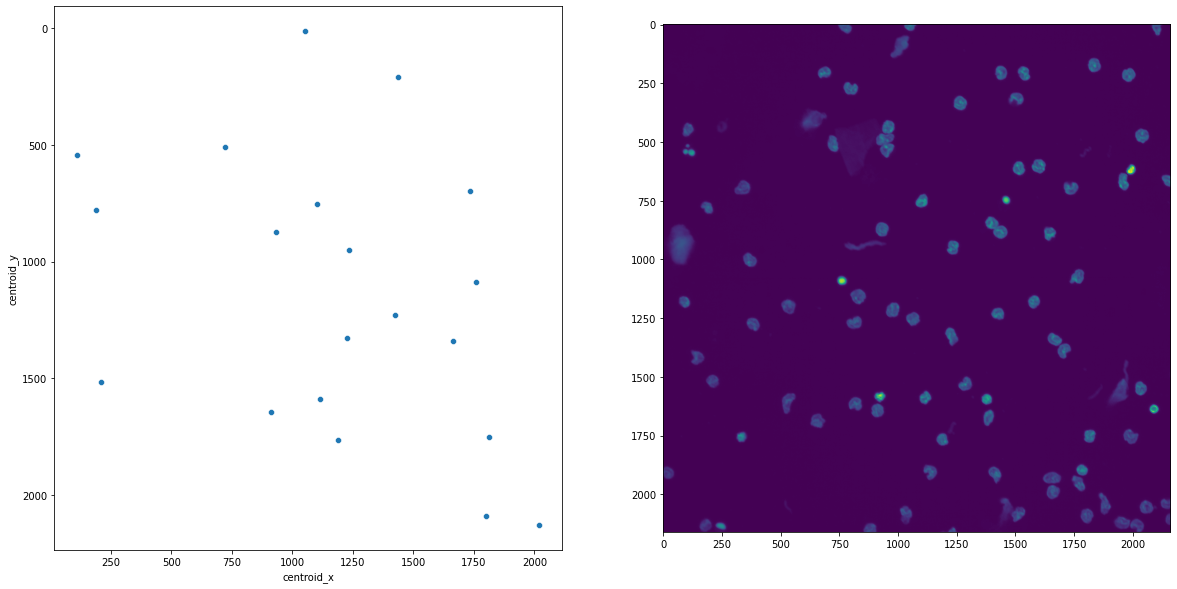

In [164]:
graph1 = features[(features.well==w) & (features.fov_64==f)].copy()
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
sns.scatterplot(data=graph1, x='centroid_x', y='centroid_y', ax=ax[0])
ax[0].invert_yaxis()
ax[1].imshow(image1)

In [173]:
graph1.loc[graph1.id==cid]

,NUCLEUS METCENTER-X,NUCLEUS METCENTER-Y,well,fov_256,donor,id,umap_x,umap_y,fov_64,resolution_x,resolution_y,center_x,center_y,centroid_x,centroid_y,image_name,image_path


1291 1391 1614 1714


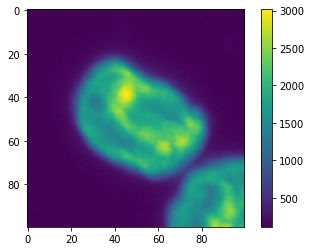

In [178]:
cid = 9
if graph1.loc[graph1.id==cid].shape[0] > 0:
    ymi = int(graph1.loc[graph1.id==cid].centroid_x.iloc[0] - 50)
    yma = int(graph1.loc[graph1.id==cid].centroid_x.iloc[0] + 50)
    xmi = int(graph1.loc[graph1.id==cid].centroid_y.iloc[0] - 50)
    xma = int(graph1.loc[graph1.id==cid].centroid_y.iloc[0] + 50)
    def ccc(cc):
        if cc <= 0:
            return 0
        elif cc >= image1.shape[0]:
            return image1.shape[0]-1
        elif cc >= image1.shape[1]:
            return image1.shape[1]-1
        else:
            return cc
    xmi = ccc(xmi)
    xma = ccc(xma)
    ymi = ccc(ymi)
    yma = ccc(yma)
    print(xmi, xma, ymi, yma)
    plt.imshow(image1[xmi:xma, ymi:yma])
    plt.colorbar()

In [181]:
features.to_csv('ea5/umap.csv', index=False)

In [182]:
features

,NUCLEUS METCENTER-X,NUCLEUS METCENTER-Y,well,fov_256,donor,id,umap_x,umap_y,fov_64,resolution_x,resolution_y,center_x,center_y,centroid_x,centroid_y,image_name,image_path
0,3799.229492,21876.675781,H2,159,AML1_M2,9,-1.207413,5.416854,39,0.149494,0.149494,3854.702855,21767.972983,708.925877,1807.138106,p1_wH2_t1_m39_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
1,3905.091064,4040.277588,B2,234,AML1_M2,1,1.668570,5.921109,58,0.149494,0.149494,3854.702855,4161.464855,1417.058363,269.350406,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
2,3974.551758,4129.835938,B2,234,AML1_M2,7,-1.211912,5.889323,58,0.149494,0.149494,3854.702855,4161.464855,1881.696971,868.426874,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
3,3892.813477,4116.119629,B2,234,AML1_M2,12,-1.311539,5.806268,58,0.149494,0.149494,3854.702855,4161.464855,1334.930745,776.675321,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
4,3856.181641,4145.979980,B2,234,AML1_M2,16,3.439832,-0.883217,58,0.149494,0.149494,3854.702855,4161.464855,1089.891941,976.418103,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52201,53157.781250,2883.951416,B18,109,Donor_141,44,-2.943622,-2.181488,27,0.149494,0.149494,53259.484529,2934.417855,399.683297,742.418346,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52202,53250.867188,2785.493652,B18,109,Donor_141,46,-0.468263,8.207773,27,0.149494,0.149494,53259.484529,2934.417855,1022.356614,83.811644,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52203,53114.757812,2867.605469,B18,109,Donor_141,57,0.092512,-0.518103,27,0.149494,0.149494,53259.484529,2934.417855,111.889595,633.076532,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52204,53225.570312,2932.076904,B18,109,Donor_141,62,2.321954,2.511270,27,0.149494,0.149494,53259.484529,2934.417855,853.139980,1064.340843,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...


In [183]:
for i in [1,2,3,4,5]:
    features[f'c{i}_imgpath'] = [pl.replace('_c1_', f'_c{i}_') for pl in features.image_path]

In [184]:
features

,NUCLEUS METCENTER-X,NUCLEUS METCENTER-Y,well,fov_256,donor,id,umap_x,umap_y,fov_64,resolution_x,...,center_y,centroid_x,centroid_y,image_name,image_path,c1_imgpath,c2_imgpath,c3_imgpath,c4_imgpath,c5_imgpath
0,3799.229492,21876.675781,H2,159,AML1_M2,9,-1.207413,5.416854,39,0.149494,...,21767.972983,708.925877,1807.138106,p1_wH2_t1_m39_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
1,3905.091064,4040.277588,B2,234,AML1_M2,1,1.668570,5.921109,58,0.149494,...,4161.464855,1417.058363,269.350406,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
2,3974.551758,4129.835938,B2,234,AML1_M2,7,-1.211912,5.889323,58,0.149494,...,4161.464855,1881.696971,868.426874,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
3,3892.813477,4116.119629,B2,234,AML1_M2,12,-1.311539,5.806268,58,0.149494,...,4161.464855,1334.930745,776.675321,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
4,3856.181641,4145.979980,B2,234,AML1_M2,16,3.439832,-0.883217,58,0.149494,...,4161.464855,1089.891941,976.418103,p1_wB2_t1_m58_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52201,53157.781250,2883.951416,B18,109,Donor_141,44,-2.943622,-2.181488,27,0.149494,...,2934.417855,399.683297,742.418346,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52202,53250.867188,2785.493652,B18,109,Donor_141,46,-0.468263,8.207773,27,0.149494,...,2934.417855,1022.356614,83.811644,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52203,53114.757812,2867.605469,B18,109,Donor_141,57,0.092512,-0.518103,27,0.149494,...,2934.417855,111.889595,633.076532,p1_wB18_t1_m27_c1_z0_l1_o0.png,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...,/mnt/fimm/EA5 Caroline/Julius_interactive plot...
52204,53225.570312,2932.076904,B18,109,Donor_141,62,2.321954,2.511270,27,0.149494,...,2934.417855,853.139980,1064.340843,p1_wB18

In [185]:
features.to_csv('ea5_Julius/umap.csv', index=False)